&nbsp;

# 4. Optimization 
Optimization is the process of finding the best combination of hyperparameters that minimize your loss function. Optimizing your machine learning algorithms is an important step when making predictions because not every machine learning problem is the same and in comparison, not every solution will be appropriate. Finding the best hyperparameters for your specific solution will ensure that your model will be optimized to your specific problem and will accurately make predictions with a more robust mapping function. 

In [1]:
# Standard libraries. 
import pandas as pd
import numpy as np 
import os
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

# Importing our functions. 
import functions
import visuals

# Importing emsemble models. 
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor

# Import transformers.  
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Renders plotly figs into svg static images. 
import plotly.io as pio
pio.renderers.default = "svg"

In [2]:
root = os.getcwd() # Setting root directory as cwd. 
df = pd.read_csv(r"{}\train.csv".format(root)) # Importing the train set.
processed = pd.read_csv(r"{}\processed.csv".format(root)) # Importing the processed train dataset.
processed.head(2)

,car name_amc ambassador brougham,car name_amc ambassador dpl,car name_amc ambassador sst,car name_amc concord,car name_amc concord dl,car name_amc concord dl 6,car name_amc gremlin,car name_amc hornet,car name_amc hornet sportabout (sw),car name_amc matador,...,car name_vw rabbit,car name_vw rabbit c (diesel),cylinders,displacement,horsepower,weight,acceleration,model year,origin,mpg
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,6.0,173.0,110.0,2725.0,12.6,81.0,1.0,23.5
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,8.0,400.0,170.0,4746.0,12.0,71.0,1.0,13.0


&nbsp;

### Section A: Dimensionality Reduction
Principle Component Analysis (PCA) is a feature elimination technqiue used to speed up processing time during training. The main idea is to get rid of similiar features whilst still retaining information of the feature space. Generally, we would want to preserve a an explained variance of between 95-99%. The way PCA works is that it creates a new set of linear features derived from our orginal feature space. 

**A.1: Choosing n_components**<br>
The first step into conducting PCA is to choose the optimal "n_components", which is basically saying how many features would you like PCA to create. We can find the optinal "n_components" by applying the Elbow Method.

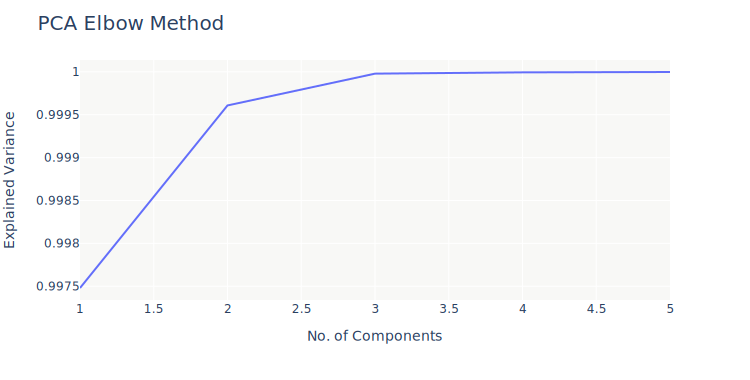

In [3]:
# Splitting the data. 
X = processed.iloc[:,:-1]
y = processed.iloc[:,-1]

# Store variance output. 
explained_variance = list()

# Cycle through explained variance for each no. of features. 
# The reason we use a range of (1, 6) is because the eblow is too difficult to see if we use all 711 features. 
for x in range(1, 6):
    pca = PCA(n_components=x)
    pca.fit(X)    
    explained_variance.append(np.sum(pca.explained_variance_ratio_))

# Plotting explained variance against no. of components. 
fig = px.line(x=range(1,6), y=explained_variance)
fig.update_layout(title='PCA Elbow Method',
                       xaxis_title='No. of Components',  
                       yaxis_title='Explained Variance', height=380, width=750, plot_bgcolor='#F8F8F6', title_font_size=20, 
                       title_font_family='Arial Black') 
fig.show()

* At 3 principle components our dataset will have 100% variance, which means it will retain 100% oof the info after the transformation. If we move down 1 principle component, we will have a 99.999% variance, which is just as good.
* In this case, since the trade off for increasing 1 principle component is 0.001% variance increase, we'll set n_components=2.

In [4]:
# The model_evaluation() class sets up the pipeline to transform the data then returns a cross validated score. 
GBC_pca = functions.model_evaluation()
GBC_pca.preprocessing(df)
GBC_pca.add_pipe_component("pca", PCA(n_components=2))
GBC_pca.add_pipe_component("clf", GradientBoostingRegressor())
GBC_pca.cross_validation(df)

print("Our PCA transformed dataset scored an MSE of: %.2f" % (GBC_pca.cv_result))

Our PCA transformed dataset scored an MSE of: 20.79


* Hold on a second, why did our MSE almost double in error?
* It seems even though 2 principle components retains enough information, the performance of the dataset is not favourable. So what we can do is iterate over a range of n_components and use the best score that does not degrade our model performance too harshly.

In [5]:
# Store results from each iteration of n_components. 
pca_resultsGBR = dict()
pca_resultsRFR = dict()
pca_resultsXGB = dict()

**A.2: Gradient Boosting Regressor PCA**<br>
Let's now use our GBR model and iterate over n_components and find the lowest MSE.

In [6]:
functions.optimal_components(GradientBoostingRegressor(), pca_resultsGBR, df) 
new_value = min(pca_resultsGBR, key=pca_resultsGBR.get)
print("The optimal PCA configuration for Gradient Boosting Regressior is: n_component=%s, with an MSE of %.2f: " 
      % (new_value, pca_resultsGBR[str(new_value)]))

The optimal PCA configuration for Gradient Boosting Regressior is: n_component=4, with an MSE of 9.90: 


**A.3: Random Forest Regressor PCA**<br>
Let's now use our RFR model and iterate over n_components and find the lowest MSE.

In [7]:
functions.optimal_components(RandomForestRegressor(), pca_resultsRFR, df) 
new_value = min(pca_resultsRFR, key=pca_resultsRFR.get)
print("The optimal PCA configuration for Random Forest Regressor is: n_component=%s, with an MSE of %.2f: "
      % (new_value, pca_resultsRFR[str(new_value)]))

The optimal PCA configuration for Random Forest Regressor is: n_component=4, with an MSE of 10.25: 


**A.4: XGB Regressor PCA**<br>
Let's now use our XGB model and iterate over n_components and find the lowest MSE.

In [8]:
functions.optimal_components(XGBRegressor(), pca_resultsXGB, df) 
new_value = min(pca_resultsXGB, key=pca_resultsXGB.get)
print("The optimal PCA configuration for XGB Regressor is: n_component=%s, with an MSE of %.2f: " 
      % (new_value, pca_resultsXGB[str(new_value)]))

The optimal PCA configuration for XGB Regressor is: n_component=6, with an MSE of 10.79: 


| Model | Model Type | n_components | MSE |
|---------|---------|---------|---------|
| **Gradient Boosting Regressor** | PCA Gradient Boosting Regressor | 4 |9.77 |
| **Random Forest Regressor** | PCA Random Forest Regressor | 4 |9.98 |
| **XGB Regressor** | PCA XGB Regressor | 6 |10.79 |

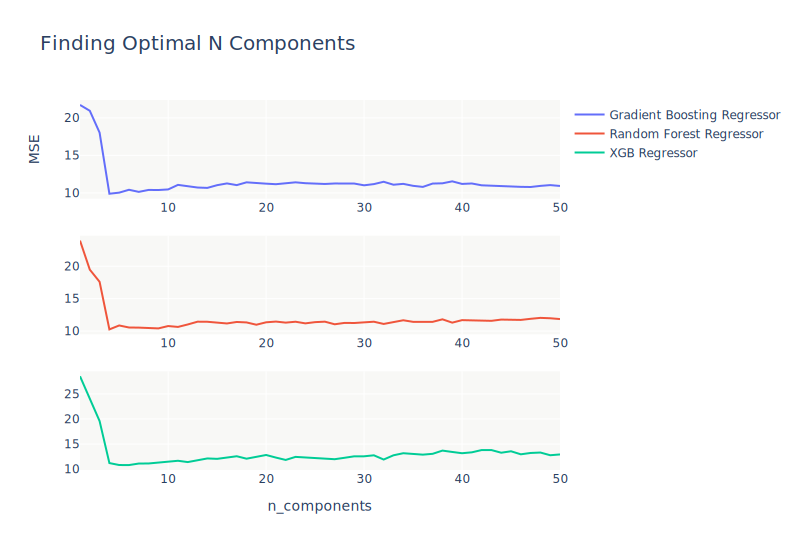

In [9]:
# Setting up axes for each subplot.  
x_axis  = list(range(1,51))
y_axisGBR = list(pca_resultsGBR.values())
y_axisRFR = list(pca_resultsRFR.values())
y_axisXGB = list(pca_resultsXGB.values())

# Plotting results. 
visuals.n_components_plot(xaxis=x_axis, yGBR=y_axisGBR, yRFR=y_axisRFR, yXGB=y_axisXGB)

&nbsp;

### Section B: Grid Search Cross Validation
Grid Search Cross Validation is a hyperparameter tuning technique where the user specifies a "parameter grid" (A list of parameters provided with the values they want to test) then evaluates each and every combination using cross validation before outputting the best feature combination for your algorithm. 

**B.1: Gradient Boosting Regressor**<br>
Let's now implement the grid search cross validation algorithm to our Gradient Boosting model to find the best combination of hypertuned parameters.

In [10]:
# Splitting the data into features and label.
X = processed.iloc[:,:-1] 
y = processed.iloc[:,-1]

In [11]:
# Creating our class instance for our GBR. 
GBR_gs = functions.model_evaluation()

# Adding parameter grid. 
GBR_gs.add_params_component('n_estimators', [50, 250, 500])
GBR_gs.add_params_component('min_samples_split', [2, 30, 50])
GBR_gs.add_params_component('max_depth', [2, 20, 50])
GBR_gs.add_params_component('learning_rate', [0.1, 0.01, 0.001])
# Evaluate using grid search. 
GBR_gs.grid_search(X, y, GradientBoostingRegressor())

Best: -9.013894 using {'learning_rate': 0.1, 'max_depth': 20, 'min_samples_split': 50, 'n_estimators': 50}


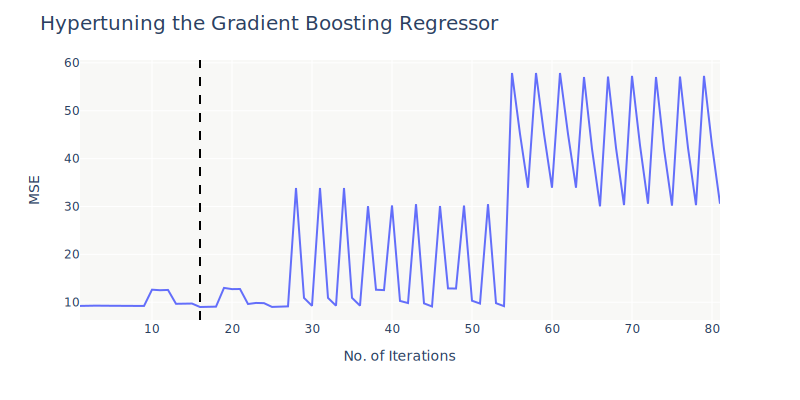

In [12]:
# Plotting results. 
visuals.grid_search_plot(GBR_gs, "Gradient Boosting Regressor")

* The lowest MSE achieved by grid search was at 8.97.
* Also note, there seems to be a recurring pattern that increases in size after iteration 55. 

**B.2: Random Forest Regressor**<br>
Let's now implement the grid search cross validation algorithm to our Random Forest model to find the best combination of hypertuned parameters.

In [13]:
# Creating our class instance for RFR. 
RFR_gs = functions.model_evaluation()

# Adding parameter grid.
RFR_gs.add_params_component('n_estimators', [50, 250, 500])
RFR_gs.add_params_component('min_samples_split', [2, 30, 50])
RFR_gs.add_params_component('min_samples_leaf', [2, 10, 25])
RFR_gs.add_params_component('max_depth', [2, 20, 50])
# Evaluate using grid search. 
RFR_gs.grid_search(X, y, RandomForestRegressor())

Best: -8.806740 using {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 250}


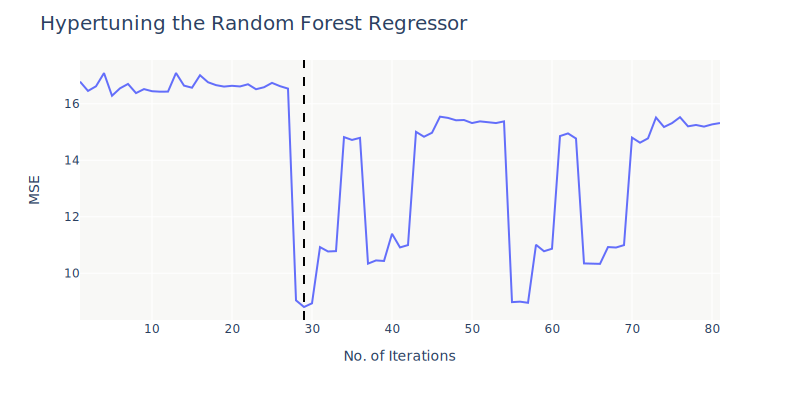

In [14]:
# Plotting results. 
visuals.grid_search_plot(RFR_gs, "Random Forest Regressor")

* The lowest MSE achieved through grid search was at 8.85. 
* Unlike the GBR output the RFR grid search starts off with a high MSE then suddenly drops.
* After the initial drop, there is a recurring pattern of points. 

**B.3: XGB Regressor**<br>
Let's now implement the grid search cross validation algorithm to our XGB model to find the best combination of hypertuned parameters.

In [15]:
# Creating our class instance for RFR. 
XGB_gs = functions.model_evaluation()

# Adding parameter grid.
XGB_gs.add_params_component('n_estimators', [50, 250, 500])
XGB_gs.add_params_component('min_child_weight', [1, 5, 15])
XGB_gs.add_params_component('max_depth', [2, 20, 50])
XGB_gs.add_params_component('learning_rate', [0.1, 0.01, 0.001])
# Evaluate using grid search. 
XGB_gs.grid_search(X, y, XGBRegressor())

Best: -8.873260 using {'learning_rate': 0.1, 'max_depth': 20, 'min_child_weight': 15, 'n_estimators': 250}


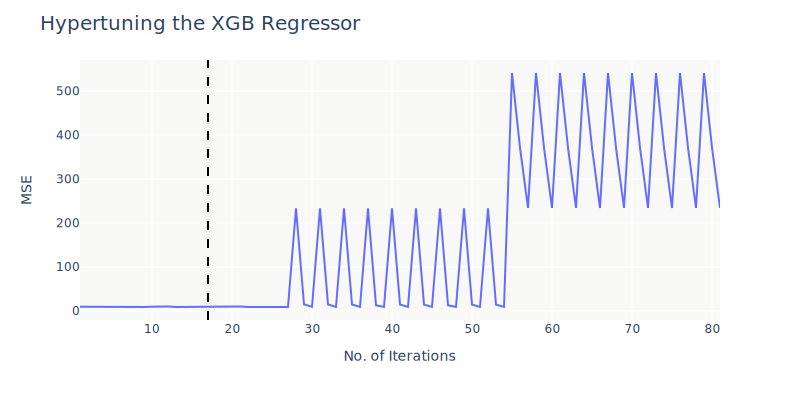

In [16]:
# Plotting results. 
visuals.grid_search_plot(XGB_gs, "XGB Regressor")

* The best MSE solved by grid search was at 8.87. 
* Just like our GBR, there seems to be a recurring pattern that increases again at the 55th iteration.

**B.4: Conclusion**<br>
In conclusion our dataset is small enough to process quickly without the need to dimensionality reduction. In terms of the grid search algorithm our Random Forest Regressor scored the best result with a MSE of 8.85 followed by our XGB Regressor with a score of 8.87 and finally our Gradient Boosting Regressor with an MSE of 8.97.

&nbsp;

| Model | GridSearch CV Score | Final Model | 
|---------|---------|---------|
| **Gradient Boosting Regressor** |8.97 |GradientBoostingRegressor(learning_rate=0.1, max_depth=20, min_samples_split=50, n_estimators=50) | 
| **Random Forest Regressor** |8.85 |RandomForestRegressor(max_depth=50, min_samples_leaf=2, min_samples_split=2, n_estimators=250) | 
| **XGB Regressor** |8.87 |XGBRegressor(learning_rate=0.1, max_depth=20, min_child_weight=15, n_estimators=250) | 

&nbsp;

&nbsp;
**Author:** Aaron Chew&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **|** &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Date Published:** 11/08/2022 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**|** &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Email:** aaronsamuelchew@gmail.com &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**|**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **GitHub:** https://github.com/aaron-chew  